In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [3]:
# Charger les données
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
store_data = pd.read_csv("store.csv")


# Remplacer les valeurs manquantes dans store_data pour CompetitionDistance par la médiane
store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].median(), inplace=True)
# Remplacer les valeurs manquantes dans store_data pour StoreType par la valeur la plus fréquente
store_data['StoreType'].fillna(store_data['StoreType'].mode()[0], inplace=True)


# Convertir la colonne "Date" en type de données de date/heure dans train_data et test_data
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])


# Extraire des fonctionnalités de la date dans train_data et test_data
train_data['Year'] = train_data['Date'].dt.year
train_data['Month'] = train_data['Date'].dt.month
train_data['Day'] = train_data['Date'].dt.day
test_data['Year'] = test_data['Date'].dt.year
test_data['Month'] = test_data['Date'].dt.month
test_data['Day'] = test_data['Date'].dt.day

# Fusionner les données
train_merged = pd.merge(train_data, store_data, on='Store')
test_merged = pd.merge(test_data, store_data, on='Store')


# Utiliser One-Hot Encoding pour les variables catégorielles dans train_merged et test_merged
train_merged = pd.get_dummies(train_merged, columns=['StoreType', 'Assortment', 'StateHoliday'])
test_merged = pd.get_dummies(test_merged, columns=['StoreType', 'Assortment', 'StateHoliday'])

# Supprimer les colonnes non nécessaires
train_merged.drop(['Date'], axis=1, inplace=True)
test_merged.drop(['Date'], axis=1, inplace=True)

# Afficher les premières lignes des données prétraitées
print(train_merged.head())
print(test_merged.head())



   Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  Year  \
0      1          5   5263        555     1    1.0            1.0  2015   
1      1          4   5020        546     1    1.0            1.0  2015   
2      1          3   4782        523     1    1.0            1.0  2015   
3      1          2   5011        560     1    1.0            1.0  2015   
4      1          1   6102        612     1    1.0            1.0  2015   

   Month  Day  ...  StoreType_a  StoreType_b  StoreType_c  StoreType_d  \
0      7   31  ...        False        False         True        False   
1      7   30  ...        False        False         True        False   
2      7   29  ...        False        False         True        False   
3      7   28  ...        False        False         True        False   
4      7   27  ...        False        False         True        False   

   Assortment_a  Assortment_b Assortment_c  StateHoliday_0  StateHoliday_a  \
0          True         Fa

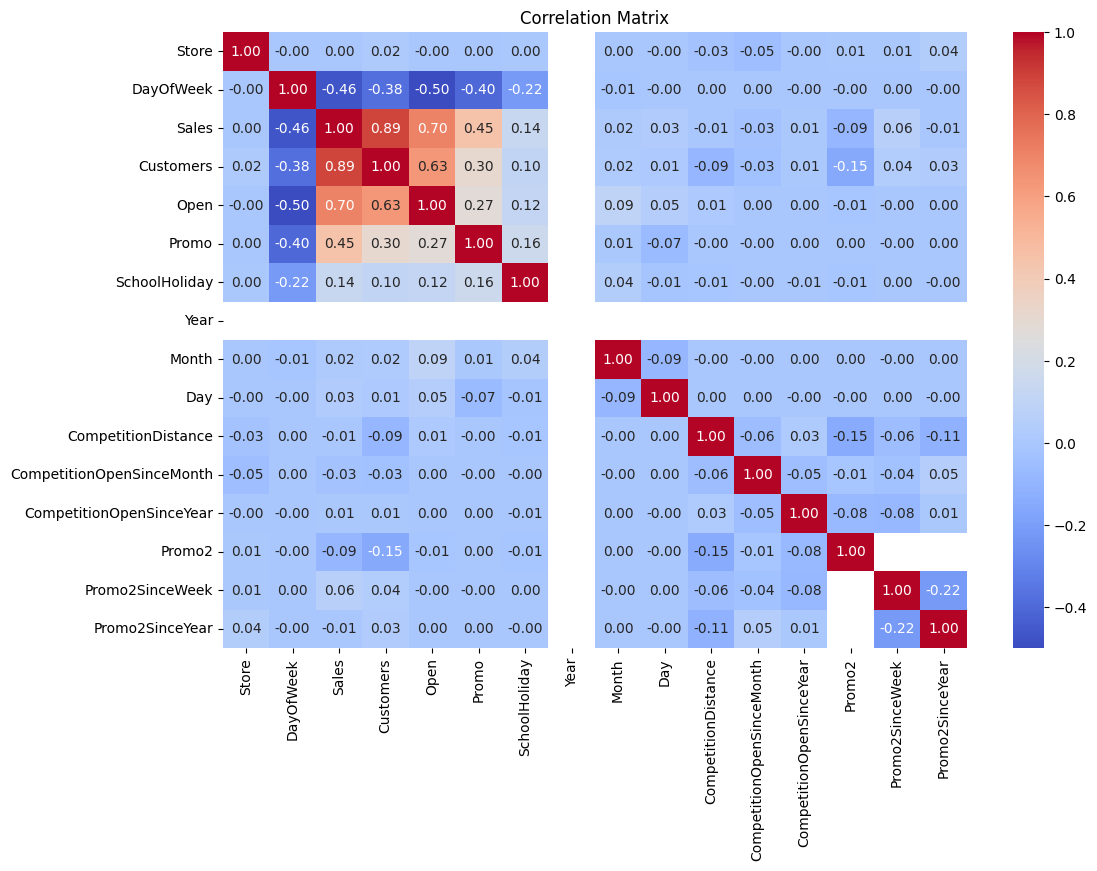

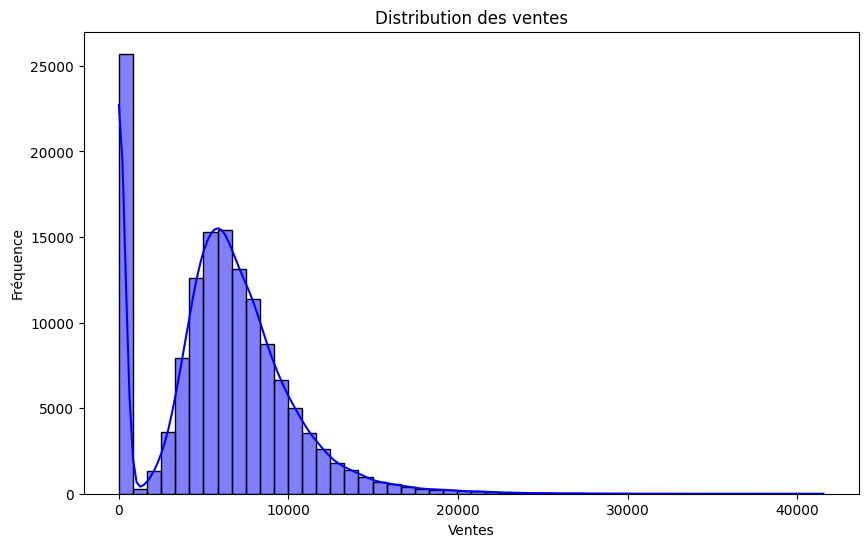

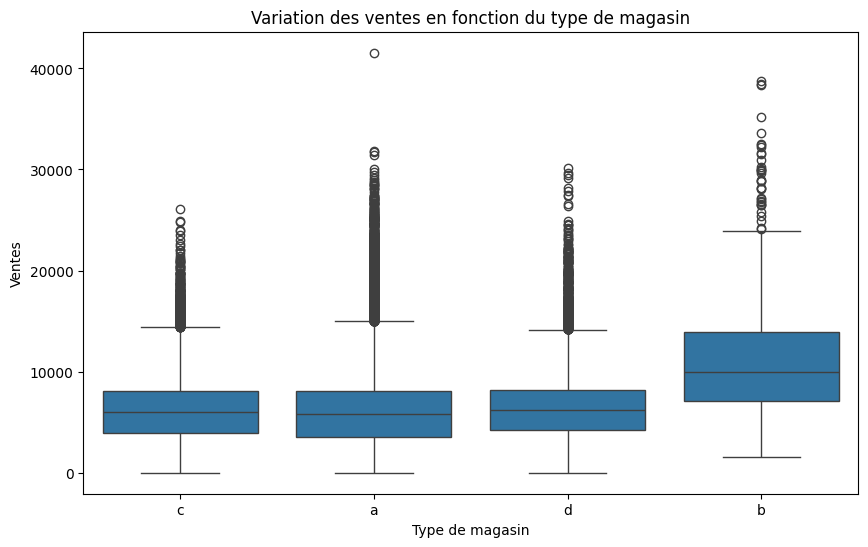

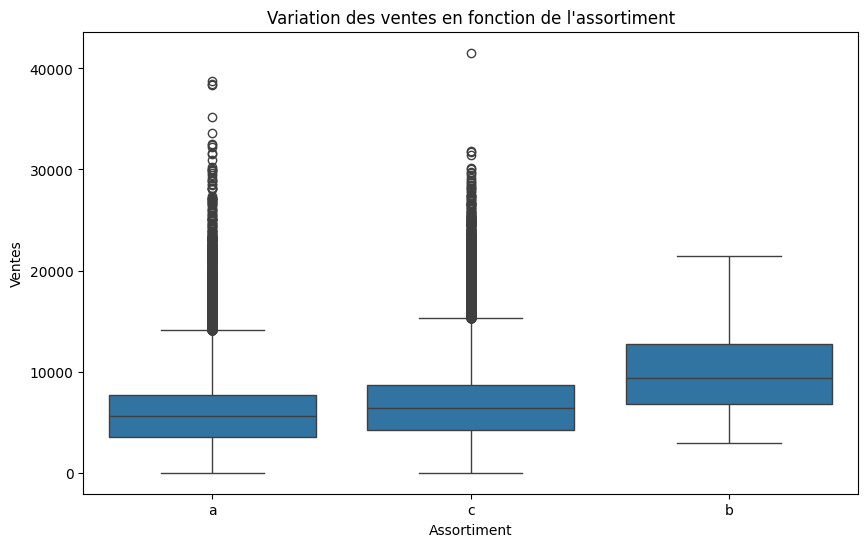

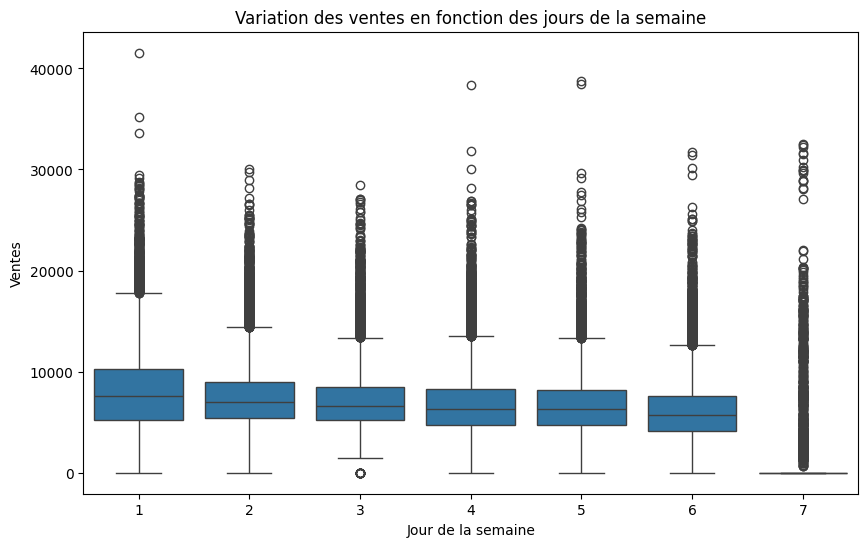

In [4]:
# Charger les données prétraitées

combined_data = pd.merge(train_data, store_data, on='Store')


# Sélectionner uniquement les colonnes numériques
numeric_columns = combined_data.select_dtypes(include=['number'])

# Calculer la matrice de corrélation pour les colonnes numériques
correlation_matrix = numeric_columns.corr()

# Afficher la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()
# Distribution des ventes
plt.figure(figsize=(10, 6))
sns.histplot(combined_data['Sales'], bins=50, kde=True, color='blue')
plt.title('Distribution des ventes')
plt.xlabel('Ventes')
plt.ylabel('Fréquence')
plt.show()

# Variation des ventes en fonction du type de magasin
plt.figure(figsize=(10, 6))
sns.boxplot(x='StoreType', y='Sales', data=combined_data)
plt.title('Variation des ventes en fonction du type de magasin')
plt.xlabel('Type de magasin')
plt.ylabel('Ventes')
plt.show()

# Variation des ventes en fonction de l'assortiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='Assortment', y='Sales', data=combined_data)
plt.title('Variation des ventes en fonction de l\'assortiment')
plt.xlabel('Assortiment')
plt.ylabel('Ventes')
plt.show()

# Variation des ventes en fonction des jours de la semaine
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='Sales', data=combined_data)
plt.title('Variation des ventes en fonction des jours de la semaine')
plt.xlabel('Jour de la semaine')
plt.ylabel('Ventes')
plt.show()

In [13]:
# Diviser les données en ensembles d'entraînement et de test
X = train_merged.drop(['Sales'], axis=1)
y = train_merged['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sélectionner les colonnes numériques et catégorielles
numeric_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Imputer les valeurs manquantes dans les caractéristiques numériques avec la médiane
numeric_imputer = SimpleImputer(strategy='median')
X_train[numeric_features] = numeric_imputer.fit_transform(X_train[numeric_features])
X_test[numeric_features] = numeric_imputer.transform(X_test[numeric_features])

# Imputer les valeurs manquantes dans les caractéristiques catégorielles avec une nouvelle catégorie
categorical_imputer = SimpleImputer(strategy='constant', fill_value='Missing')
X_train[categorical_features] = categorical_imputer.fit_transform(X_train[categorical_features])
X_test[categorical_features] = categorical_imputer.transform(X_test[categorical_features])

# Normaliser les caractéristiques numériques
numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features)
    ]
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Initialiser les modèles
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Support Vector Machine': SVR()
}

# Entraîner et évaluer les modèles
for name, model in models.items():
    print(f'Entraînement du modèle {name}...')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f'RMSE pour {name}: {rmse:.2f}')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Entraînement du modèle Linear Regression...
RMSE pour Linear Regression: 1539.89
Entraînement du modèle Decision Tree...
RMSE pour Decision Tree: 878.02
Entraînement du modèle Random Forest...
RMSE pour Random Forest: 587.61
Entraînement du modèle K-Nearest Neighbors...
RMSE pour K-Nearest Neighbors: 1183.72
Entraînement du modèle Support Vector Machine...
RMSE pour Support Vector Machine: 2523.99


In [16]:
# Définir la grille d'évaluation personnalisée
evaluation_grid = {
    'RMSE': mean_squared_error,
    'MAE': mean_absolute_error,
    'R²': r2_score,
    'MedAE': median_absolute_error,
}

# Définir la fonction pour calculer MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Ajouter MAPE à la grille d'évaluation
evaluation_grid['MAPE'] = mean_absolute_percentage_error

# Évaluer chaque modèle
for name, model in models.items():
    print(f'Évaluation du modèle {name}...')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results = {}
    for metric_name, metric_func in evaluation_grid.items():
        # Vérifier si la métrique est MAPE pour traiter différemment
        if metric_name == 'MAPE':
              # Calculer MAPE
            results[metric_name] = mean_absolute_percentage_error(y_test, y_pred)
        else:
              # Calculer les autres métriques
            results[metric_name] = metric_func(y_test, y_pred)
    print(results)

Évaluation du modèle Linear Regression...
{'RMSE': 2371251.050759816, 'MAE': 1046.3502102187701, 'R²': 0.8520803765083208, 'MedAE': 740.75, 'MAPE': inf}
Évaluation du modèle Decision Tree...
{'RMSE': 770916.8391291954, 'MAE': 498.24225040974846, 'R²': 0.9519098880100247, 'MedAE': 289.0, 'MAPE': 8.370480398894719}
Évaluation du modèle Random Forest...
{'RMSE': 345286.96447911346, 'MAE': 353.2165139314473, 'R²': 0.9784608560253586, 'MedAE': 219.42500000000018, 'MAPE': 6.019766483199721}
Évaluation du modèle K-Nearest Neighbors...
{'RMSE': 1401194.4365566878, 'MAE': 780.5103399130619, 'R²': 0.9125929102160282, 'MedAE': 537.0999999999999, 'MAPE': inf}
Évaluation du modèle Support Vector Machine...
{'RMSE': 6370522.32394357, 'MAE': 1702.9447998216897, 'R²': 0.6026041766850785, 'MedAE': 1202.962331454819, 'MAPE': inf}


In [17]:
# Définir la taille de la fenêtre pour la moyenne mobile
window_size = 7
# Calculer la moyenne mobile sur les données de test
rolling_mean = y_test.rolling(window=window_size).mean().fillna(method='bfill')

# Calculer les métriques de performance pour la moyenne mobile
rolling_mean_rmse = np.sqrt(mean_squared_error(y_test[window_size:], rolling_mean[window_size:]))
rolling_mean_mae = mean_absolute_error(y_test[window_size:], rolling_mean[window_size:])
rolling_mean_r2 = r2_score(y_test[window_size:], rolling_mean[window_size:])

# Afficher les résultats de comparaison
print("Comparaison des performances avec la moyenne mobile :")
print(f"RMSE: {rolling_mean_rmse:.2f}")
print(f"MAE: {rolling_mean_mae:.2f}")
print(f"R²: {rolling_mean_r2:.2f}")

# Comparer avec les modèles d'apprentissage automatique
for name, model in models.items():
    print(f'Évaluation du modèle {name}...')
    model.fit(X_train_scaled, y_train)
    # Prédire sur l'ensemble de test
    y_pred = model.predict(X_test_scaled)
     # Calculer les métriques d'évaluation
    results = {}
    for metric_name, metric_func in evaluation_grid.items():
        if metric_name == 'MAPE':
            results[metric_name] = mean_absolute_percentage_error(y_test, y_pred)
        else:
            results[metric_name] = metric_func(y_test, y_pred)
             # Afficher les résultats
    print(results)

Comparaison des performances avec la moyenne mobile :
RMSE: 3704.26
MAE: 2876.36
R²: 0.14
Évaluation du modèle Linear Regression...
{'RMSE': 2371251.050759816, 'MAE': 1046.3502102187701, 'R²': 0.8520803765083208, 'MedAE': 740.75, 'MAPE': inf}
Évaluation du modèle Decision Tree...
{'RMSE': 770916.8391291954, 'MAE': 498.24225040974846, 'R²': 0.9519098880100247, 'MedAE': 289.0, 'MAPE': 8.370480398894719}
Évaluation du modèle Random Forest...
{'RMSE': 345286.96447911346, 'MAE': 353.2165139314473, 'R²': 0.9784608560253586, 'MedAE': 219.42500000000018, 'MAPE': 6.019766483199721}
Évaluation du modèle K-Nearest Neighbors...
{'RMSE': 1401194.4365566878, 'MAE': 780.5103399130619, 'R²': 0.9125929102160282, 'MedAE': 537.0999999999999, 'MAPE': inf}
Évaluation du modèle Support Vector Machine...
{'RMSE': 6370522.32394357, 'MAE': 1702.9447998216897, 'R²': 0.6026041766850785, 'MedAE': 1202.962331454819, 'MAPE': inf}
